# Homework 1

Image generated with ChatGPT

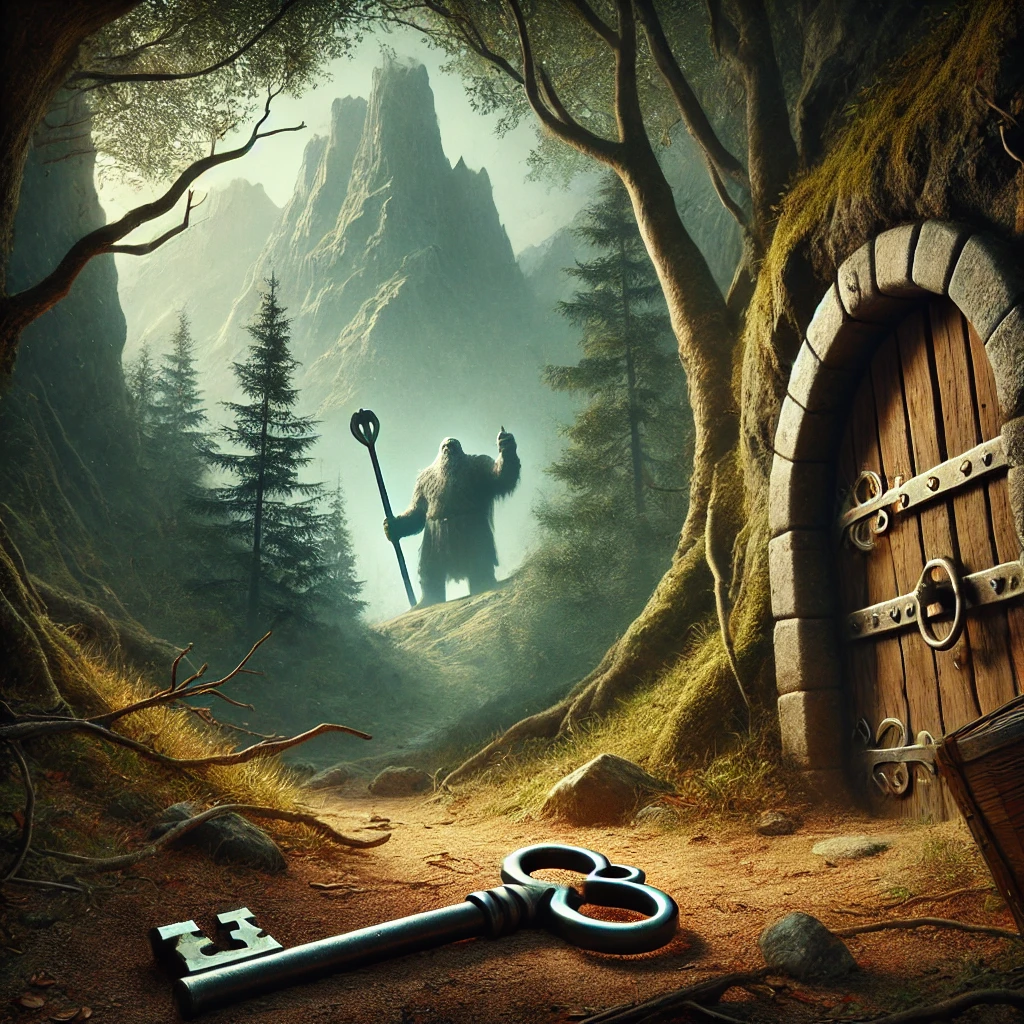

### Import Text Adventures

In [1]:
from text_adventure_games import (
    games, parsing, actions, things, blocks, viz
)

## Locations

In [2]:

clearing = things.Location(
    "Clearing",
    "You are in a forest clearing. \nYou see a path leading north to a cave and another path leading east to the mountain pass. \nThere is a key on the ground."
)
cave = things.Location(
    "Cave",
    "Inside the cave, you find a sword.",
)
mountain_pass = things.Location(
    "Mountain Pass",
    "You have made it through the mountain pass. Congratulations, you win!"
)
death = things.Location(
    "The Afterlife",
    "You are dead. GAME OVER."
)
death.set_property("game_over", True)


# Map of Locations
clearing.add_connection("north", cave)
clearing.add_connection("east", mountain_pass)

###  Preliminary Game Map

Here is a visualization of the locations represented as a directed graph.

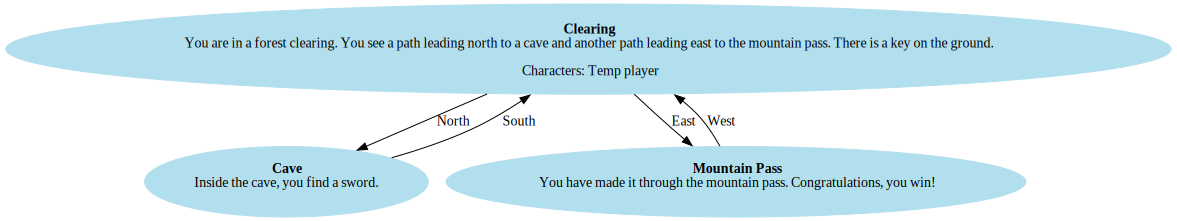

In [3]:
tempgame = games.Game(clearing, things.Character(name="Temp Player", description="", persona=""))

from text_adventure_games.viz import Visualizer
viz = Visualizer(tempgame)
graph = viz.visualize()
graph

## Items

### Gettable Items

In [4]:
key = things.Item(
    "key",
    "A small, rusty key with intricate engravings",
    "It looks like it could unlock something important.",
)
clearing.add_item(key)

sword = things.Item(
    "sword",
    "A sharp, well-crafted sword with a gleaming blade",
    "Perfect for defending yourself against dangerous foes.",
)
sword.set_property("is_weapon", True)
sword.add_command_hint("Attack orge with sword")
cave.add_item(sword)

### Scenery Items

_We called these "non-gettable" in the tutorial_

In [5]:
door = things.Item(
    "door",
    "The cave door is locked",
    "Its surface covered in moss and old carvings. The keyhole gleams faintly, hinting at something hidden within."
)
door.set_property("gettable", False)
door.set_property("is_locked", True)
door.add_command_hint("unlock door")
clearing.add_item(door)

## Characters

### Player

In [6]:
# Player
player = things.Character(
    name="The player",
    description="You are a simple peasant destined for greatness.",
    persona="I am on an adventure.",
)

### Non-Player Characters (NPCs)

In [7]:
# A Troll at the drawbridge
ogre = things.Character(
    name="ogre",
    description="A towering ogre looms in the mountain pass",
    persona="It grips a massive club, its eyes glaring at you with a mix of hunger and malice, ready to attack any who dare approach.",
)
ogre.set_property("character_type", "ogre")
ogre.set_property("is_conscious", True)
clearing.add_character(ogre)

## Actions

In [8]:
class Unlock_Door(actions.Action):
    ACTION_NAME = "unlock door"
    ACTION_DESCRIPTION = "Unlock a door with a key"
    ACTION_ALIASES = []
    
    def __init__(self, game, command):
        super().__init__(game)
        # TODO - your code here
        self.command = command
        self.character = self.parser.get_character(command)
        self.key = self.parser.match_item(
            "key", self.parser.get_items_in_scope(self.character)
        )
        self.door = self.parser.match_item(
            "door", self.parser.get_items_in_scope(self.character)
        )
        # HINT: take a look at text_adventures/actions for some examples of actions!

    def check_preconditions(self) -> bool:
        """
        Preconditions:
        * There must be a door
        * The character must be at the same location as the door
        * The door must be locked
        * The character must have the key in their inventory
        """
        # TODO - your code here
        if self.door and self.door.get_property("is_locked") and self.key:
            return True
        else:
            return False

    def apply_effects(self):
        """
        Effects:
        * Unlocks the door
        """
        # TODO - your code here
        self.door.set_property("is_locked", False)
        self.parser.ok("Door is unlocked")

## Blocks

In text adventure games, _blocks_ are essentially puzzles to unlock the next stage in the game.

We give you a `Troll_Block` for an example of what an implementation looks like.

You should implement:
* The guard block (similar to the troll block)
* The darkness block (unblocked if any character at the location is carrying
  a lit item (like a lamp or candle)
* A locked door block

In [9]:
# Sample Block

class Ogre_Block(blocks.Block):
    """
    Blocks progress in this direction until the troll is no longer hungry, or
    leaves, or is unconscious, or dead.
    """

    def __init__(self, location: things.Location, ogre: things.Character):
        super().__init__(
            "You have no weapon to defend yourself.", "The ogre attacks and kills you."
        )
        self.location = location
        self.ogre = ogre
        items = list(player.inventory.keys())
        self.win = False
        for item_name in items:
            if player.inventory[item_name].get_property("is_weapon"):
                self.win = True

    def is_blocked(self) -> bool:
        if self.ogre:
            if not self.location.here(self.ogre):
                return False
            if self.ogre.get_property("is_unconscious"):
                return False
        if not self.win:
                return True
        return False


In [10]:
class Door_Block(blocks.Block):
    """
    Blocks progress in this direction until the character unlocks the door.
    """

    def __init__(self, location: things.Location, door: things.Item):
        super().__init__("A locked door blocks your way", "The door ahead is locked.")
        # TODO - your code here
        self.location = location
        self.door = door

    def is_blocked(self) -> bool:
        # Conditions of block:
        # * The door is locked
        # TODO - your code here
        if self.door.get_property("is_locked"):
            return True
        return False

In [11]:
# TODO Add blocks to location to:
# * the courtyard - the guard prevents you from going East
# * the dungeon_stairs - the darkness prevents you from going Down
# * the tower stairs - the locked door prevents you from going Up

door_block = Door_Block(clearing, door)
clearing.add_block("north", door_block)
ogre_block = Ogre_Block(clearing, ogre)
clearing.add_block("east", ogre_block)


## Play Action Castle

In [12]:
class ActionCastle(games.Game):
    def __init__(
        self, start_at: things.Location, player: things.Character, characters=None,
        custom_actions=None
    ):
        super().__init__(start_at, player, characters=characters, custom_actions=custom_actions)

    def is_won(self) -> bool:
        """ 
        Checks whether the game has been won. For Action Castle, the game is won
        once any character is sitting on the throne (has the property is_reigning).
        """
        for name, character in self.characters.items():
            if character.get_property("is_reigning"):
                msg = "{name} is now reigns in ACTION CASTLE! {name} has won the game!"
                self.parser.ok(msg.format(name=character.name.title()), self)
                return True
        return False

In [13]:
characters = [ogre]
custom_actions = [Unlock_Door]

# The Game
game = ActionCastle(clearing, player, characters=characters, custom_actions=custom_actions)


In [14]:
game.game_loop()

You are in a forest clearing.
You see a path leading north to a cave and another path leading east to the
mountain pass.
There is a key on the ground.
Exits:
North to Cave
East to Mountain Pass

You see:
 * A small, rusty key with intricate engravings
 * The cave door is locked
        unlock door
Characters:
 *
 * A towering ogre looms in the mountain pass




>  north


The door ahead is locked.



>  east


The ogre attacks and kills you.



>  take key


The player got the key.



>  unlock door


Door is unlocked



>  nourth


No action found for nourth
I'm not sure what you want to do.



>  north


Inside the cave, you find a sword.
Exits:
South to Clearing

You see:
 * A sharp, well-crafted sword with a gleaming blade
        Attack orge with sword





>  take sword


The player got the sword.



>  south


You are in a forest clearing.
You see a path leading north to a cave and another path leading east to the
mountain pass.
There is a key on the ground.
Exits:
North to Cave
East to Mountain Pass

You see:
 * The cave door is locked
        unlock door
Characters:
 *
 * A towering ogre looms in the mountain pass




>  attack ogre with sword


The player attacked ogre with the sword.
Ogre was knocked unconscious.



>  east


You have made it through the mountain pass. Congratulations, you win!
Exits:
West to Clearing






KeyboardInterrupt: Interrupted by user